In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, reduce, repeat

In [2]:
!wget https://raw.githubusercontent.com/MASTREX/List-of-Indian-Names/master/2.%20First.txt -O names-indian.txt

--2024-05-30 09:41:48--  https://raw.githubusercontent.com/MASTREX/List-of-Indian-Names/master/2.%20First.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8752 (8.5K) [text/plain]
Saving to: ‘names-indian.txt’

names-indian.txt    100%[===================>]   8.55K  --.-KB/s    in 0s      

2024-05-30 09:41:49 (33.8 MB/s) - ‘names-indian.txt’ saved [8752/8752]



In [3]:
import pandas as pd
pd.read_csv('names-indian.txt', header=None)

,0
0,Abhishek
1,Aman
2,Harsh
3,Ayush
4,Aditi
...,...
1160,Prasoon
1161,Madhusudan
1162,Prastuti
1163,Rampratap


In [4]:
# convert all names to lowercase
names = pd.read_csv('names-indian.txt', header=None)[0].str.lower().values

In [5]:
names

array(['abhishek', 'aman', 'harsh', ..., 'prastuti', 'rampratap',
       'madhukar'], dtype=object)

Text(0, 0.5, 'Density')

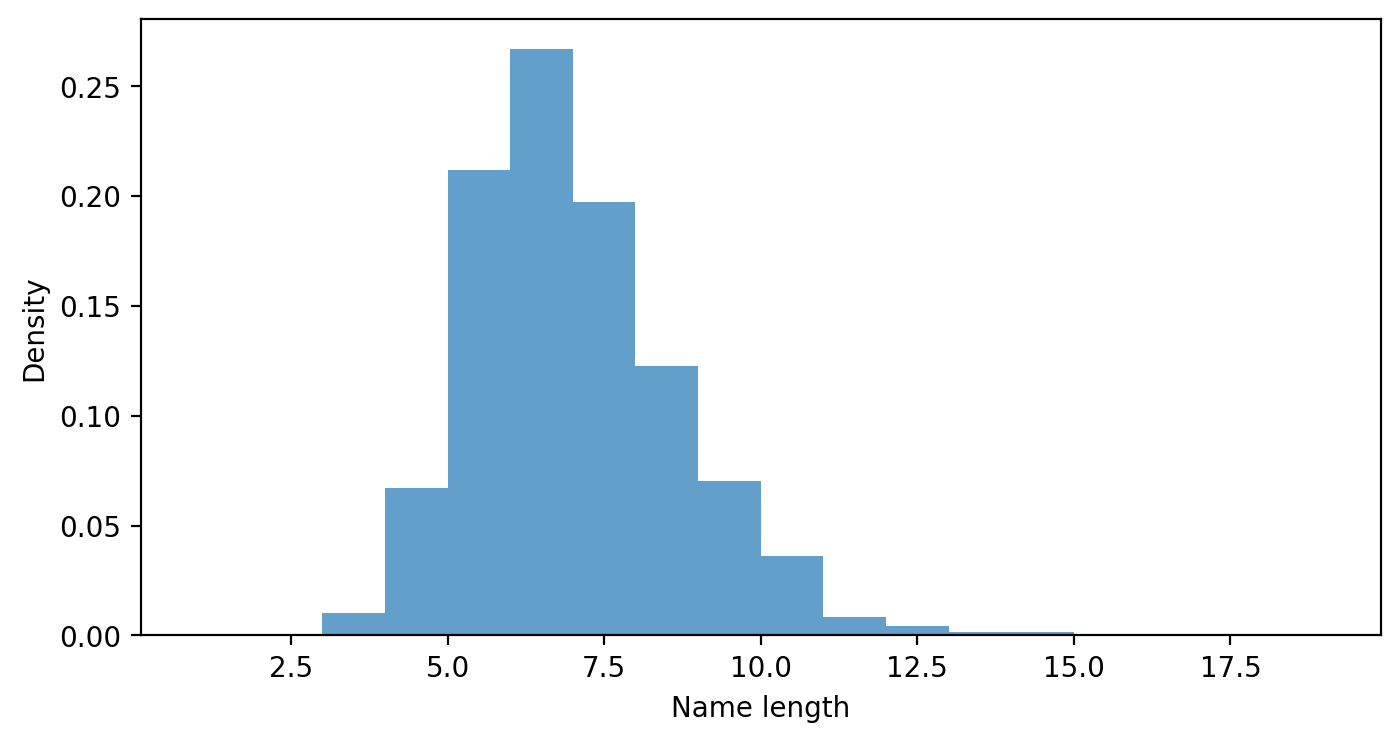

In [7]:
# KDE plot of name lengths
plt.figure(figsize=(8, 4))
plt.hist([len(name) for name in names], bins=range(1, 20), density=True, alpha=0.7)
plt.xlabel('Name length')
plt.ylabel('Density')

In [8]:
# Attach START and END tokens to each name. Need to add these two to the vocabulary.
start_symbol = '^'
end_symbol = '$'

names = [start_symbol + name + end_symbol for name in names]
names[:5]


['^abhishek$', '^aman$', '^harsh$', '^ayush$', '^aditi$']

In [10]:
# Find unique characters in the dataset
vocab = set(''.join(names))
vocab = sorted(vocab)
print(vocab, len(vocab))

['$', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 28


In [25]:
# Create a d dimensional lookup table for each character in the vocabulary
class CharTable:
    def __init__(self, vocab):
        self.vocab = vocab
        self.char2index = {c: i for i, c in enumerate(vocab)}
        self.index2char = {i: c for i, c in enumerate(vocab)}
        self.vocab_size = len(vocab)
    
    def encode(self, name):
        return torch.tensor([self.char2index[c] for c in name])
    
    def decode(self, tensor):
        if type(tensor) == torch.Tensor:
            tensor = tensor.cpu().numpy()
        return ''.join([self.index2char[i] for i in tensor])

In [26]:
ct = CharTable(vocab)

In [27]:
ct.encode('^'), ct.encode('$'), ct.encode('a'), ct.encode('z'), ct.encode('ab'), ct.encode('za')

(tensor([1]),
 tensor([0]),
 tensor([2]),
 tensor([27]),
 tensor([2, 3]),
 tensor([27,  2]))

In [28]:
ct.decode([1]), ct.decode(torch.tensor([1])), ct.decode(torch.tensor([1, 2, 3]))

('^', '^', '^ab')

In [29]:
# create embedding layer
class CharEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(CharEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
    def forward(self, x):
        return self.embedding(x)


In [30]:
char_embedding = CharEmbedding(ct.vocab_size, 2)


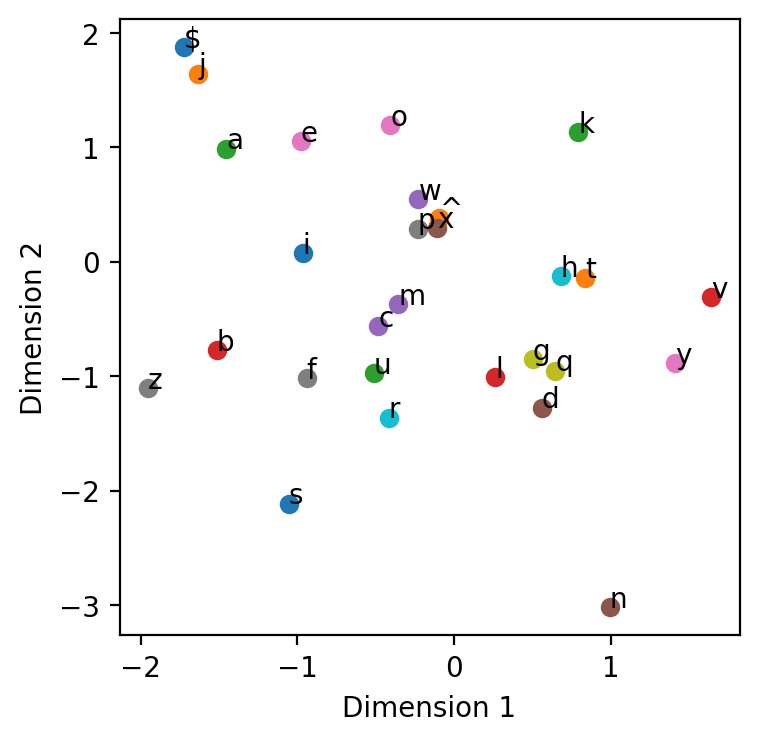

In [33]:
def plot_2d_embeddings(embedding, vocab):
    plt.figure(figsize=(4, 4))
    for i, char in enumerate(vocab):
        tensor = ct.encode(char)
        embedding = char_embedding(tensor)
        plt.scatter(embedding[0, 0].item(), embedding[0, 1].item())
        plt.text(embedding[0, 0].item(), embedding[0, 1].item(), char)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

plot_2d_embeddings(char_embedding, vocab)

In [34]:
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [35]:
rnn = RNN(2, 128, ct.vocab_size)

In [46]:
# Predict the next character given the current character
current_char = "a"
print("Current character:", current_char)
# convert to tensor
current_tensor = ct.encode(current_char)
print("Curent tensor:", current_tensor)
# Look up the embedding
current_embedding = char_embedding(current_tensor)
print("Current embedding:", current_embedding)
# Initialize the hidden state
hidden = rnn.init_hidden()
#print(hidden)
# Pass the embedding and hidden state through the RNN
output, hidden = rnn(current_embedding, hidden)
print(output)

# Print the predicted character (most probable)
_, predicted_index = output.topk(1)
# flatten the tensor
predicted_index = predicted_index.squeeze().item()
# convert to character
predicted_char = ct.decode([predicted_index])
print("Predicted character:", predicted_char)


Current character: a
Curent tensor: tensor([2])
Current embedding: tensor([[-1.4545,  0.9880]], grad_fn=<EmbeddingBackward0>)
tensor([[-2.5902, -3.3533, -3.8653, -3.9548, -3.5940, -2.8801, -3.4821, -3.0470,
         -3.5943, -3.5595, -3.6062, -3.5047, -3.6877, -3.3012, -3.7079, -4.4289,
         -2.9308, -3.6200, -3.3797, -3.7172, -2.8883, -2.6247, -3.7265, -3.3239,
         -3.7247, -2.9247, -3.4027, -3.2497]], grad_fn=<LogSoftmaxBackward0>)
Predicted character: $


In [90]:
# Create a function to generate a word (sequence of characters) given a 
# starting sequence of characters (stops when END token is predicted) 
# or if the length of the generated word exceeds a certain limit of 10 characters
def create_name(start_string, rnn, char_embedding, ct):
    with torch.no_grad():
        # start with the last character in the start_string
        current_char = start_string[-1]
        current_tensor = ct.encode(current_char)
        current_embedding = char_embedding(current_tensor)
        hidden = rnn.init_hidden()
        name = start_string
        while current_char != end_symbol and len(name) < 10:
            output, hidden = rnn(current_embedding, hidden)
            # Find the next character by sampling from the output distribution
            predicted_index = torch.multinomial(torch.exp(output), 1).item()
            current_char = ct.decode([predicted_index])
            _, predicted_index = output.topk(1)
            predicted_index = predicted_index.squeeze().item()
            current_char = ct.decode([predicted_index])
            name += current_char
            current_tensor = ct.encode(current_char)
            current_embedding = char_embedding(current_tensor)
        return name
    

In [91]:
create_name('^a', rnn, char_embedding, ct)

'^anm$'

In [92]:
create_name('^c', rnn, char_embedding, ct)

'^c$'

In [93]:
# Generate dataset for training
def generate_data(names, ct):
    X = []
    Y = []
    for name in names:
        for i in range(1, len(name)):
            X.append(name[i-1])
            Y.append(name[i])
    X = [ct.encode(x) for x in X]
    Y = [ct.encode(y) for y in Y]
    return X, Y

X, Y = generate_data(names, ct)

In [57]:
X[0], Y[0], X[1], Y[1], X[2], Y[2]

(tensor([1]), tensor([2]))

In [62]:
print(names[0])
print(ct.decode(X[0]), ct.decode(Y[0]))
print(ct.decode(X[1]), ct.decode(Y[1]))
print(ct.decode(X[2]), ct.decode(Y[2]))

^abhishek$
^ a
a b
b h


In [115]:
# Training loop
num_epochs = 12
learning_rate = 3e-4
embedding_size = 8
hidden_size = 32
rnn = RNN(embedding_size, hidden_size, ct.vocab_size)
embedding = CharEmbedding(ct.vocab_size, embedding_size)

optimizer = torch.optim.Adam(list(rnn.parameters()) + list(embedding.parameters()), lr=learning_rate)

criterion = nn.NLLLoss()

for epoch in range(num_epochs):
    total_loss = 0
    for i in range(len(X)):
        optimizer.zero_grad()
        hidden = rnn.init_hidden()
        input_tensor = X[i]
        target_tensor = Y[i].squeeze()
        input_embedding = embedding(input_tensor)
        target_tensor = target_tensor.unsqueeze(0)
        output, hidden = rnn(input_embedding, hidden)
        
        predicted_next_char = output.argmax().item()
        
        loss = criterion(output, target_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        #print(i, loss.item())
    if (epoch+1) % 1 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {total_loss/len(X)}')

Epoch: 1/12, Loss: 2.684675631081001
Epoch: 2/12, Loss: 2.4274482760898484
Epoch: 3/12, Loss: 2.3604175581492934
Epoch: 4/12, Loss: 2.3314669918697972
Epoch: 5/12, Loss: 2.3155676853116023
Epoch: 6/12, Loss: 2.3054449003057
Epoch: 7/12, Loss: 2.2983417296262845
Epoch: 8/12, Loss: 2.2929774504282614
Epoch: 9/12, Loss: 2.2887099773854604
Epoch: 10/12, Loss: 2.2851798680263626
Epoch: 11/12, Loss: 2.2821793051528485
Epoch: 12/12, Loss: 2.2795761335450453


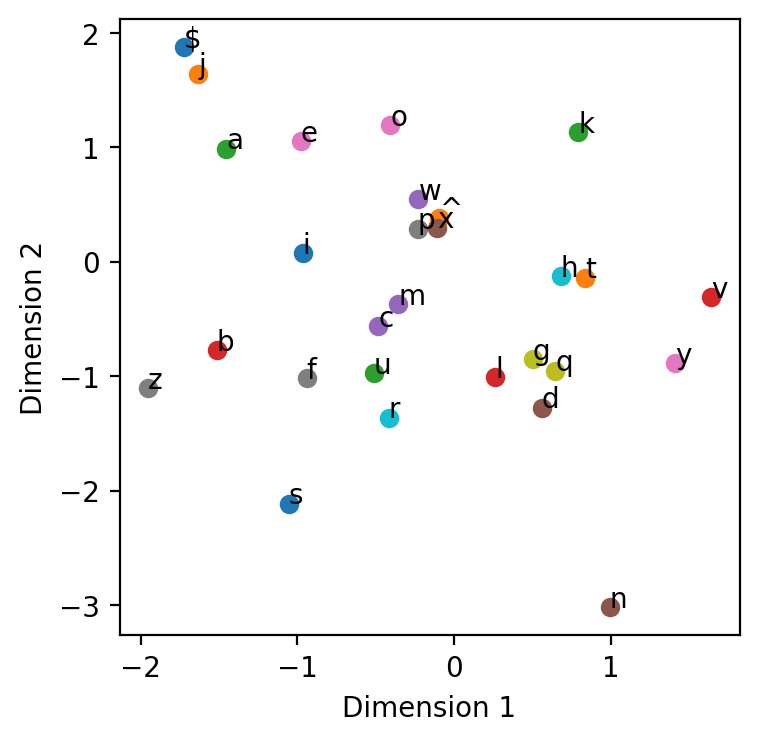

In [116]:
plot_2d_embeddings(embedding, vocab)

In [117]:
create_name('^a', rnn, embedding, ct)

'^an$'

In [118]:
create_name('^b', rnn, embedding, ct)

'^bhan$'

In [119]:
create_name('^c', rnn, embedding, ct)

'^chan$'

In [120]:
create_name('^d', rnn, embedding, ct)

'^dan$'

In [121]:
create_name('^n', rnn, embedding, ct)

'^n$'